In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow import keras
from keras.layers import Dense, Dropout
import random

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

2025-04-09 14:48:40.552341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Get Data

make sampling even

1. reduce the dataset (253680,) by sampling a smaller size (50736 rows)
2. min-max scale the features to account for different ranges in data like BMI
3. add an intercept bias term to features
4. split into training/test data

**Note**: diabetes_012 has three classes
- 0: no diabetes or only during pregnancy
- 1: prediabetes
- 2: diabetes

In [2]:
df = pd.read_csv('../archive/diabetes_012_health_indicators_BRFSS2015.csv')

# columns should be type int -- none are float or categorical
df = df.astype(int)
print(df.shape)

# reduce dataset by sampling 
df_small = df.sample(frac=0.2, random_state=1)
df_small.shape

df_balanced = pd.read_csv('../archive/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df_balanced = df_balanced.astype(int)

(253680, 22)


In [3]:
def getTrainTestData(df, y_label, test_size=0.25):
    """
    Splits the data into train and test sets.
    """

    # Split the data into features and target
    X = df.drop(y_label, axis=1)
    y = df[y_label].to_numpy()

    # min max scaling, rounded to 3 decimal places
    scaler = MinMaxScaler()
    X_scale = scaler.fit_transform(X).round(3)
    # Add a new column filled with ones -- for intercept/bias term
    X_scale = np.hstack((X_scale,np.ones([X_scale.shape[0],1], X_scale.dtype)))

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=test_size, random_state=1)

    return X_train, X_test, y_train, y_test

In [4]:
X_train_small, X_test_small, y_train_small, y_test_small = getTrainTestData(df_small, 'Diabetes_012')
X_train_big, X_test_big, y_train_big, y_test_big = getTrainTestData(df, 'Diabetes_012')
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = getTrainTestData(df_balanced, 'Diabetes_binary')

# Exploratory DA

Just seeing how features relate to each of the three classes

Diabetes_012
0    213703
2     35346
1      4631
Name: count, dtype: int64


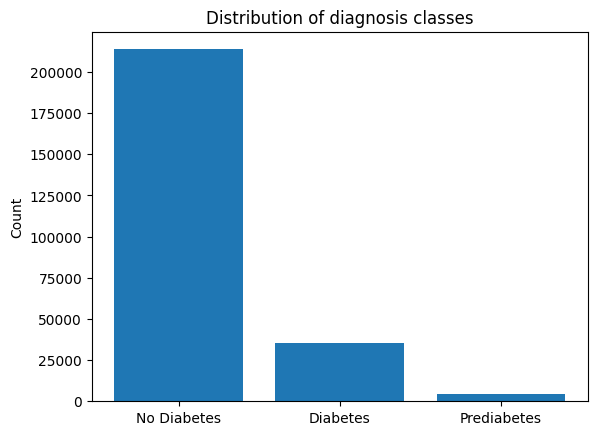

In [5]:
# the distribution of classes. As you can see, the dataset is not balanced
counts = df['Diabetes_012'].value_counts()
print(counts)

classes = ['No Diabetes', 'Prediabetes', 'Diabetes']
plt.bar(counts.index.map(lambda x: classes[x]), counts.values)

# df['Diabetes_012'].value_counts().plot(kind='bar')
plt.title('Distribution of diagnosis classes')
plt.ylabel('Count')
plt.savefig('diabetes_distribution.png')
plt.show()


In [6]:
no_diabetes = df_small.loc[df_small['Diabetes_012'] == 0, :]
pre_diabetes = df_small.loc[df_small['Diabetes_012'] == 1, :]
diabetes = df_small.loc[df_small['Diabetes_012'] == 2, :]

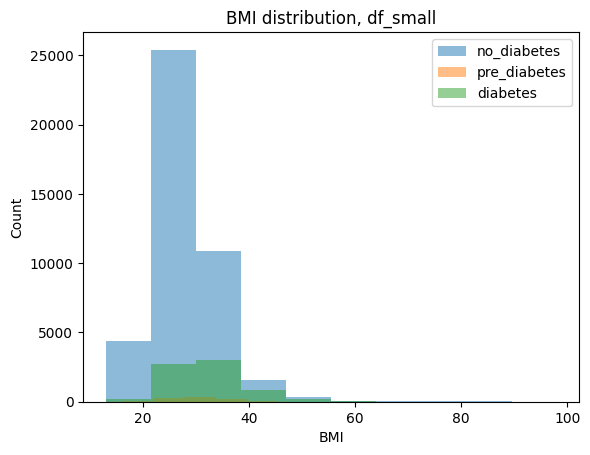

In [7]:
# plot 
plt.hist(no_diabetes['BMI'], alpha=0.5, label='no_diabetes')
plt.hist(pre_diabetes['BMI'], alpha=0.5, label='pre_diabetes')
plt.hist(diabetes['BMI'], alpha=0.5, label='diabetes')
plt.legend(loc='upper right')
plt.title('BMI distribution, df_small')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.savefig('df_small_bmi_distribution.png')
plt.show()

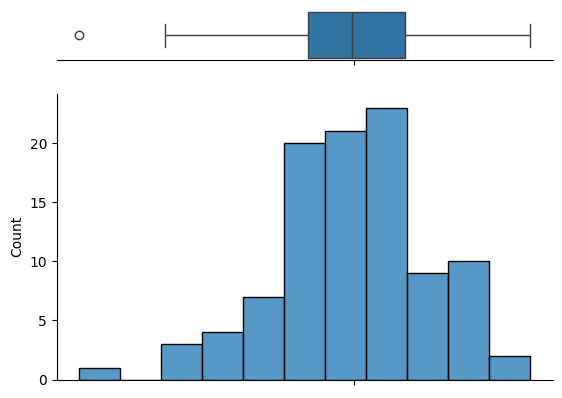

In [8]:
# test on randomly generated data, how to layer a boxplot over a histogram
x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box, vert=False)
sns.histplot(x, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

# MLP

## sklearn

- ~45 seconds to fit: 300 iterations, 1 hidden layer size 100

Loss function

ADAM: df_small
- 0.847, hidden = (50,)
- 0.848 , hidden = (15,)
- 0.846, hidden = (20,10,)
- 0.848, hidden = (20), batch_size=50 --> 20 seconds to train also

WITH BALANCED DATASET: 2 classes
- .74

In [9]:
mlp_small = MLPClassifier(
    random_state=1, 
    max_iter=300,
    batch_size=50,
    hidden_layer_sizes=(20),
    learning_rate='invscaling',
                    ).fit(X_train_small, y_train_small)

print(mlp_small.predict_proba(X_test_small[:1]))
print(mlp_small.predict(X_test_small[:5, :]))
print(mlp_small.score(X_test_small, y_test_small))

[[0.68819464 0.01720848 0.29459688]]
[0 0 0 0 0]
0.8513875748975087


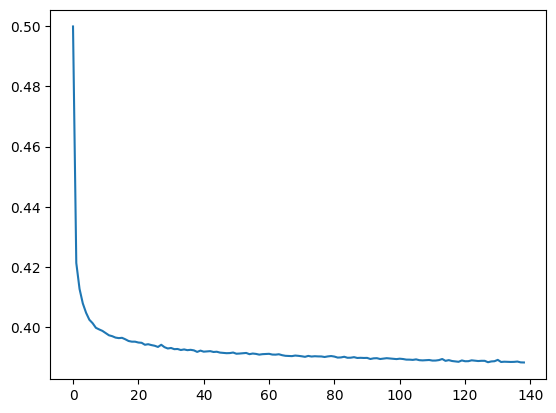

In [10]:
# plot the loss curve
plt.plot(mlp_small.loss_curve_)

In [11]:
mlp_small.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 50,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 20,
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 300,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

## keras

### small dataset:

---
**Accuracy: 0.8488273024559021**

model = keras.Sequential([
    Dense(20, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_p, epochs=10, batch_size=32)

---

**Accuracy: 0.8508356809616089**

model = keras.Sequential([
    Dense(10, activation='relu', input_shape=(22,)),
    Dense(5, activation='relu', input_shape=(10,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_small, y_train_p, epochs=5, batch_size=32, verbose=1)

---

**Accuracy: 0.8521759510040283**
model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_small, y_train_p, epochs=5, batch_size=32, verbose=1)

---

In [12]:
y_train_p = keras.utils.to_categorical(y_train_small, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_small, num_classes=3)

model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_small, y_train_p, epochs=5, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test_small, y_test_p)
accuracy

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1190/1190 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7621 - loss: 0.6328
Epoch 2/5
1190/1190 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.8444 - loss: 0.4265
Epoch 3/5
1190/1190 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8415 - loss: 0.4206
Epoch 4/5
1190/1190 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - accuracy: 0.8428 - loss: 0.4143
Epoch 5/5
1190/1190 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.8405 - loss: 0.4155
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.8569 - loss: 0.3893


0.8486281633377075

In [13]:
# plot the confusion matrix
def plot_confusion_matrix(y_actual, y_pred, labels, title='Confusion Matrix', save_path=None):
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    if (save_path != None):
        plt.savefig(save_path)
    plt.show()

397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


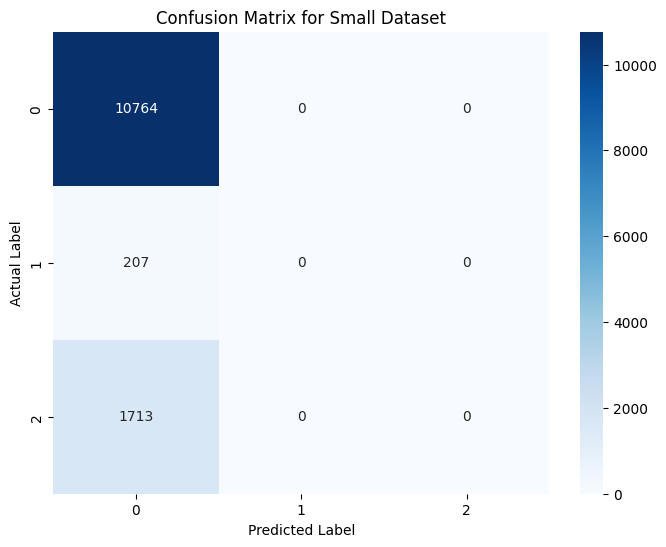

In [14]:
y_prob = model.predict(X_test_small) 
y_classes = y_prob.argmax(axis=-1)
plot_confusion_matrix(y_test_small, 
                      y_classes, 
                      labels=[0, 1, 2], 
                      title='Confusion Matrix for Small Dataset', 
                      save_path='df_small_keras_confusion_matrix.png')

## balanced dataset

---

**Accuracy: 0.7466757297515869**

model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(2, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_balanced, y_train_p, epochs=5, batch_size=32, verbose=1)

---

In [15]:
y_train_p = keras.utils.to_categorical(y_train_balanced, num_classes=2)
y_test_p = keras.utils.to_categorical(y_test_balanced, num_classes=2)

model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(2, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_balanced, y_train_p, epochs=5, batch_size=32, verbose=1)
loss, accuracy = model.evaluate(X_test_balanced, y_test_p)
accuracy

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1657/1657 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6744 - loss: 0.6085
Epoch 2/5
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7360 - loss: 0.5312
Epoch 3/5
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7397 - loss: 0.5235
Epoch 4/5
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7386 - loss: 0.5234
Epoch 5/5
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7441 - loss: 0.5180
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - accuracy: 0.7453 - loss: 0.5102


0.74741131067276

553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


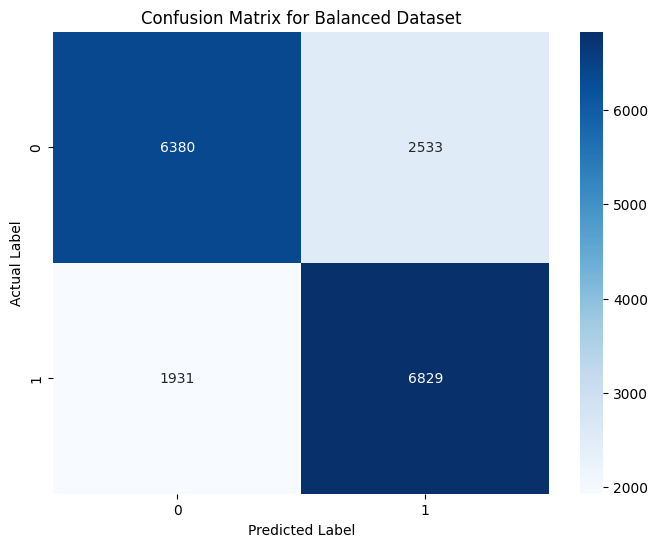

'\nThis confusion matrix looks a lot better, especially for predicting diabetes.\n'

In [16]:
y_prob = model.predict(X_test_balanced) 
y_classes = y_prob.argmax(axis=-1)
plot_confusion_matrix(y_test_balanced, 
                      y_classes, 
                      labels=[0, 1], 
                      title='Confusion Matrix for Balanced Dataset', 
                      save_path='df_balanced_keras_confusion_matrix.png')

'''
This confusion matrix looks a lot better, especially for predicting diabetes.
'''

## Scale to larger dataset

---
**Accuracy: 0.8468345999717712**

model = keras.Sequential([
    Dense(5, activation='relu', input_shape=(22,)),
    Dropout(0.2),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_big, y_train_p, epochs=4, batch_size=50, verbose=1)

---

In [17]:
y_train_p = keras.utils.to_categorical(y_train_big, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_big, num_classes=3)

model = keras.Sequential([
    Dense(5, activation='relu', input_shape=(22,)),
    Dropout(0.2),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_big, y_train_p, epochs=4, batch_size=50, verbose=1)
loss, accuracy = model.evaluate(X_test_big, y_test_p)
# predictions = model.predict(new_data)
accuracy

Epoch 1/4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3806/3806 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8296 - loss: 0.5486
Epoch 2/4
3806/3806 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8448 - loss: 0.4261
Epoch 3/4
3806/3806 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8433 - loss: 0.4232
Epoch 4/4
3806/3806 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8463 - loss: 0.4135
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 2s 774us/step - accuracy: 0.8428 - loss: 0.4034


0.844118595123291

In [18]:
y_prob = model.predict(X_test_big) 
y_classes = y_prob.argmax(axis=-1)

1982/1982 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step


In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels):
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix")
    plt.show()

In [20]:
plot_confusion_matrix(y_test_big, 
                      y_classes, 
                      labels=[0, 1, 2], 
                      title='Confusion Matrix for Big Dataset', 
                      save_path='df_big_keras_confusion_matrix.png')

'''
So basically, we do not correctly predict the pre-diabetes class at all.
- The model predicts most of the pre-diabetes class as no diabetes.
The model is also really bad at predicting diabetes. which is obviously worse
'''

TypeError: plot_confusion_matrix() got an unexpected keyword argument 'title'

# Most important features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### df small

In [ ]:
# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train_small, y_train_small)

# Make predictions on the test set
y_pred = clf.predict(X_test_small)

# Evaluate the classifier
accuracy = accuracy_score(y_test_small, y_pred)
print(f"Accuracy: {accuracy}")

confusion_matrix(y_test_small, y_pred)

Accuracy: 0.847918637653737


array([[10464,     5,   295],
       [  185,     0,    22],
       [ 1420,     2,   291]])

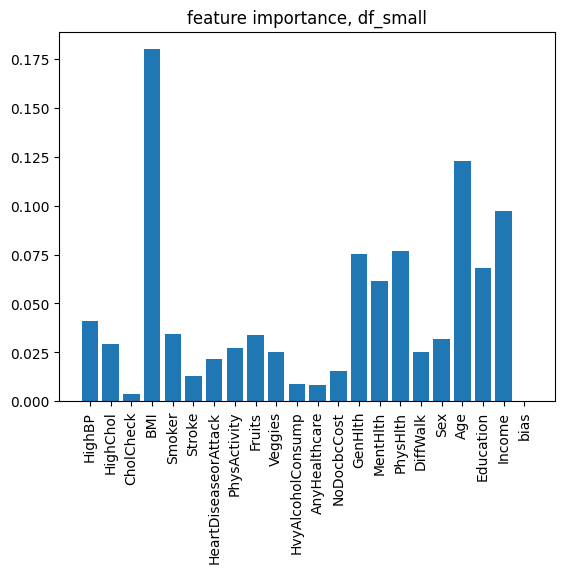

In [ ]:
features = df.columns[1:].append(pd.Index(['bias']))

plt.bar(features, clf.feature_importances_)
plt.xticks(rotation=90)
plt.title("feature importance, df_small")

plt.savefig("df_small_feature_importance.png")

plt.show()

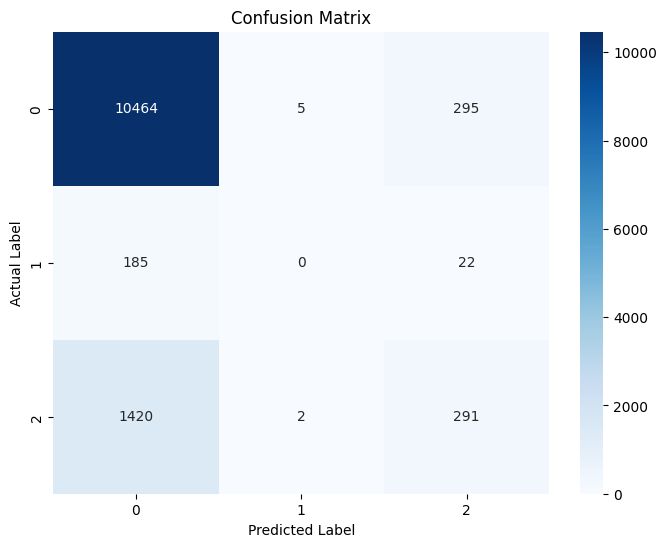

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_confusion_matrix(y_test_small, y_pred, labels=[0, 1, 2])

## df_balanced

In [ ]:
# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred = clf.predict(X_test_balanced)

# Evaluate the classifier
accuracy = accuracy_score(y_test_balanced, y_pred)
print(f"Accuracy: {accuracy}")

confusion_matrix(y_test_balanced, y_pred)

Accuracy: 0.7396593673965937


array([[6249, 2664],
       [1937, 6823]])

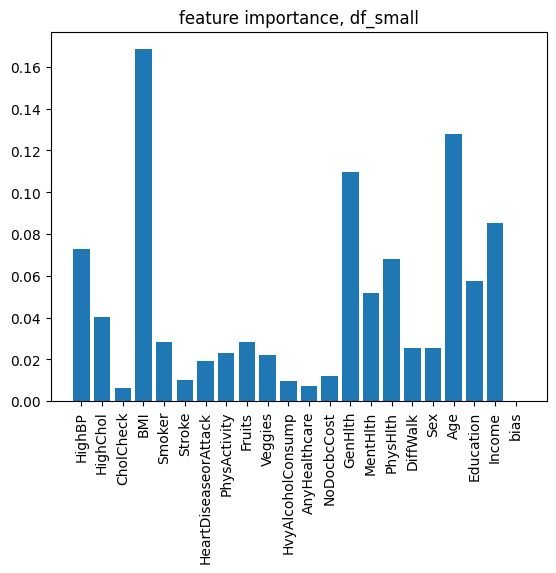

In [ ]:
features = df.columns[1:].append(pd.Index(['bias']))

plt.bar(features, clf.feature_importances_)
plt.xticks(rotation=90)
plt.title("feature importance, df_small")

plt.savefig("df_balanced_feature_importance.png")

plt.show()